## Machine Learning

### Spark setups

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# start spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2503ff9b-bebd-4b7c-80b4-d0e587a86a0f;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 402ms :: artifacts dl 40ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/30 02:29:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [48]:
bucket = 'dsan-6000-group-35'
submissions = spark.read.parquet(f"s3a://{bucket}/submissions_with_sentiment.parquet")
#comments = spark.read.parquet(f"s3a://{bucket}/comments_with_sentiment.parquet")

In [49]:
submissions.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- sentiment: string (nullable = true)



## Predicting Taylor Swift Submissions Popularity Using Machine Learning Models

In [50]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer,RegexTokenizer,StopWordsRemover,VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler
from pyspark.ml.regression import DecisionTreeRegressor,RandomForestRegressor,GBTRegressor,GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
#from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pyspark.sql.functions as f

In [109]:
# get hour data as one variable

submissions = submissions.filter(f.col('subreddit')=='TaylorSwift')

submissions = submissions.withColumn('hour', f.hour('created_utc'))\
.withColumn('is_self',f.col('is_self').cast('string'))\
.withColumn('stickied',f.col('stickied').cast('string'))\
.withColumn('num_comments',f.col('num_comments').cast('integer'))\
.withColumn('num_crossposts',f.col('num_crossposts').cast('integer'))\
.withColumn('text_length',f.length('text'))


df = submissions.select('month','hour','num_comments','num_crossposts','score','is_self','stickied','sentiment','text_length')


In [52]:
# work on string columns

# string to numeric indices

stringIndexer_sentiment = StringIndexer(inputCol="sentiment", outputCol="sentiment_idx")
stringIndexer_is_self = StringIndexer(inputCol="is_self", outputCol="is_self_idx")
stringIndexer_stickied = StringIndexer(inputCol="stickied", outputCol="stickied_idx")


# indicies to one-hot encoding

onehot_sentiment = OneHotEncoder(inputCol="sentiment_idx", outputCol="sentiment_vec")
onehot_is_self = OneHotEncoder(inputCol="is_self_idx", outputCol="is_self_vec")
onehot_stickied = OneHotEncoder(inputCol="stickied_idx", outputCol="stickied_vec")


In [59]:
# Scale the features
scaler = MinMaxScaler(inputCol = 'features', outputCol = 'features_norm')

In [60]:
# build features
vector_assembler = VectorAssembler(
    inputCols=["month","hour","num_comments","num_crossposts","is_self_vec","stickied_vec","sentiment_vec","text_length"], 
    outputCol= "features")

In [61]:
# define the model
model = RandomForestRegressor(labelCol="score", featuresCol="features_norm", numTrees=30)

In [62]:
# build the pipeline
pipeline_model = Pipeline(stages=[stringIndexer_sentiment, 
                                  stringIndexer_is_self,
                                  stringIndexer_stickied,
                                  onehot_sentiment,
                                  onehot_is_self,
                                  onehot_stickied,
                                  vector_assembler, 
                                  scaler,
                                  model])

In [63]:
# train test split
train_data, test_data = df.randomSplit([0.8,0.2],123)

In [64]:
# fit data with random forest model
model_1 = pipeline_model.fit(train_data)
y_test_pred = model_1.transform(test_data)

In [65]:
# make predictions
y_test_pred = model_1.transform(test_data)
y_train_pred = model_1.transform(train_data)


In [66]:
# save rmse and r2 values
rmse = []
r2 = []

evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")

rf_rmse = evaluator.evaluate(y_test_pred)
rmse.append(rf_rmse)


evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
rf_r2 = evaluator.evaluate(y_test_pred)
r2.append(rf_r2)

In [68]:
# fit data with decision tree model
model = DecisionTreeRegressor(labelCol="score", featuresCol="features_norm", maxDepth = 5)

pipeline_model = Pipeline(stages=[stringIndexer_sentiment, 
                                  stringIndexer_is_self,
                                  stringIndexer_stickied,
                                  onehot_sentiment,
                                  onehot_is_self,
                                  onehot_stickied,
                                  vector_assembler, 
                                  scaler,
                                  model])

model_2 = pipeline_model.fit(train_data)
y_test_pred = model_2.transform(test_data)

evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")

dt_rmse = evaluator.evaluate(y_test_pred)
rmse.append(dt_rmse)


evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
dt_r2 = evaluator.evaluate(y_test_pred)
r2.append(dt_r2)

In [69]:
# fit data with gradient boosting model
model = GBTRegressor(labelCol="score", featuresCol="features_norm", maxDepth = 5)

pipeline_model = Pipeline(stages=[stringIndexer_sentiment, 
                                  stringIndexer_is_self,
                                  stringIndexer_stickied,
                                  onehot_sentiment,
                                  onehot_is_self,
                                  onehot_stickied,
                                  vector_assembler, 
                                  scaler,
                                  model])

model_3 = pipeline_model.fit(train_data)
y_test_pred = model_3.transform(test_data)

evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")

gb_rmse = evaluator.evaluate(y_test_pred)
rmse.append(gb_rmse)


evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
gb_r2 = evaluator.evaluate(y_test_pred)
r2.append(gb_r2)

23/11/30 03:01:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/30 03:01:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [71]:
# fit data with linear model
model = GeneralizedLinearRegression(labelCol="score", featuresCol="features_norm", family = 'gaussian')
pipeline_model = Pipeline(stages=[stringIndexer_sentiment, 
                                  stringIndexer_is_self,
                                  stringIndexer_stickied,
                                  onehot_sentiment,
                                  onehot_is_self,
                                  onehot_stickied,
                                  vector_assembler, 
                                  scaler,
                                  model])

model_4 = pipeline_model.fit(train_data)
y_test_pred = model_4.transform(test_data)

evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")

glm_rmse = evaluator.evaluate(y_test_pred)
rmse.append(glm_rmse)


evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
glm_r2 = evaluator.evaluate(y_test_pred)
r2.append(glm_r2)

23/11/30 03:04:36 WARN Instrumentation: [ad8cd9ad] regParam is zero, which might cause numerical instability and overfitting.


23/11/30 03:04:37 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


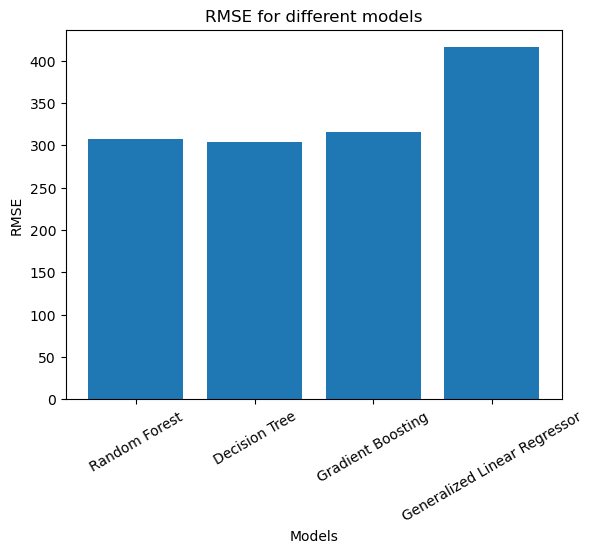

In [76]:
import matplotlib.pyplot as plt

models = ['Random Forest','Decision Tree', 'Gradient Boosting','Generalized Linear Regressor']
plt.bar(models,rmse)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE for different models')
plt.xticks(rotation = 30)
plt.savefig('yt560_RMSE_summary_table.png')
plt.show()

In [80]:
import pandas as pd
data = dict(models = models, RMSE = rmse)
rmse_df = pd.DataFrame(data)
rmse_df

,models,RMSE
0,Random Forest,308.156459
1,Decision Tree,303.792915
2,Gradient Boosting,316.153684
3,Generalized Linear Regressor,415.852005


In [82]:
rmse_df.to_csv('yt560_RMSE_summary_table.csv')

In [84]:

data = dict(models = models, R_squared = r2)
r2_df = pd.DataFrame(data)
r2_df

,models,R_squared
0,Random Forest,0.482579
1,Decision Tree,0.497129
2,Gradient Boosting,0.455375
3,Generalized Linear Regressor,0.057722


In [85]:
r2_df.to_csv('yt560_R2_summary_table.csv')

In [92]:
# save the best model for submissions
model_2.save('decision_tree_model_submissions')

In [110]:
df = stringIndexer_sentiment.fit(df).transform(df)
df = stringIndexer_is_self.fit(df).transform(df)
df = stringIndexer_stickied.fit(df).transform(df)
df = onehot_sentiment.fit(df).transform(df)
df = onehot_is_self.fit(df).transform(df)
df = onehot_stickied.fit(df).transform(df)
df = vector_assembler.transform(df)
df = scaler.fit(df).transform(df)

train_data, test_data = df.randomSplit([0.8,0.2],123)

In [114]:
dt_model = DecisionTreeRegressor(labelCol="score", featuresCol="features_norm", maxDepth = 5)
dt_model = dt_model.fit(train_data)
feature_importances = dt_model.featureImportances


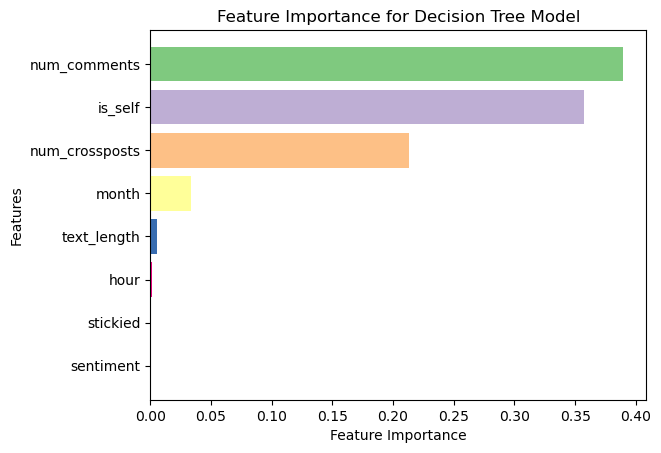

In [147]:

from matplotlib.cm import get_cmap

features = ['month','hour','num_comments','num_crossposts','is_self','stickied','sentiment','text_length']

feature_importance_table = pd.DataFrame(list(zip(features,feature_importances.toArray())),columns = ['feature_names','importance'])

feature_importance_table = feature_importance_table.sort_values(by = 'importance')

colors = []
cmap = get_cmap('Accent')

for i in range(len(features)):
    colors.append(cmap(7-i))
    
plt.barh(feature_importance_table['feature_names'],feature_importance_table['importance'],align = 'center',color = colors)
plt.title('Feature Importance for Decision Tree Model')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.savefig('yt560_feature_importance.png')
plt.show()



In [129]:
feature_importance_table.sort_values(by = 'importance',ascending = False).to_csv('feature_importance_table.csv')

### Analysis Report

To predicting the popularity (the score) of a submission post under Taylor Swift subreddit, variables including `post_month`,`post_hour`,`number_of_comments`,`number_of_crossposts`,`self_post`,`stickied`,`text_sentiment`,`text_length` are considered. Four machine learning models are applied for modeling to find the best description of data, they are Random Forest Regressor, Decision Tree Regressor, Gradient Boosting Regressor, and Generalized Linear Regressor. In the data preparation part, our team applied string-indexer to convert string-type variables into numeric indicies, and applied one-hot encoding to convert numeric indicies to multiple dimentions. Data are rescaled using MinMaxScaler to reduce computing for some algorithms. All the transformation methods (including indexers, one-hot encoding, vector assembler, and scalar) and the model are passed to a pipeline, for faster model building and computing.

Models are evaluated under two categories: R-squared and RMSE. The summary tables above represents the different model performances. It is shown that Decision Tree model received the best performance, with the smallest RMSE valued at `303` and the largest R^2 valued at `0.49`. Random Forest and Gradient Boosting models received almost the similiar result as Decision Tree model, but with a slightly bad outcome, the Generalized Linear Model did not fit the data well.

Feature importance are examined inside the Decision Tree Regressor model. The horizontal bar plot displays the importance for the variable our team considered. The top three variables affect the dependent variable `score` most are `number of comments`, `is self post`, and `number of crossposts`. Variables like `month` and `text length` have some affect on the model but ont that significant. Variables including `hour`, `stickied`, and `sentiment` are not helpful for predicting final outcomes.

